***Ex. 1*** În documentaţia pgmpy găsiţi formularea şi implementarea celebrei probleme Monty Hall. Cerinţa acestui exerciţiu
este să explicaţi problema şi codul din implementare.

In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

# Defining the network structure
model = BayesianNetwork([("C", "H"), ("P", "H")])

# Defining the CPDs:
cpd_c = TabularCPD("C", 3, [[0.33], [0.33], [0.33]])
cpd_p = TabularCPD("P", 3, [[0.33], [0.33], [0.33]])
cpd_h = TabularCPD(
    "H",
    3,
    [
        [0, 0, 0, 0, 0.5, 1, 0, 1, 0.5],
        [0.5, 0, 1, 0, 0, 0, 1, 0, 0.5],
        [0.5, 1, 0, 1, 0.5, 0, 0, 0, 0],
    ],
    evidence=["C", "P"],
    evidence_card=[3, 3],
)

# Associating the CPDs with the network structure.
model.add_cpds(cpd_c, cpd_p, cpd_h)

# Some other methods
model.get_cpds()

[<TabularCPD representing P(C:3) at 0x1f8aa708710>,
 <TabularCPD representing P(P:3) at 0x1f8aac43690>,
 <TabularCPD representing P(H:3 | C:3, P:3) at 0x1f8aac42610>]

In [3]:
# check_model check for the model structure and the associated CPD and returns True if everything is correct otherwise throws an exception
model.check_model()

True

In [4]:
# Infering the posterior probability
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
posterior_p = infer.query(["P"], evidence={"C": 0, "H": 2})
print(posterior_p)

+------+----------+
| P    |   phi(P) |
+======+==========+
| P(0) |   0.3333 |
+------+----------+
| P(1) |   0.6667 |
+------+----------+
| P(2) |   0.0000 |
+------+----------+


***Ex. 2*** Un medic doreşte să determine probabilitatea ca un pacient să aibă o anumită boală pulmonară (B), având în vedere
simptomele observate. Există trei variabile observabile care pot indica prezenţa bolii: tuse (T), dificultate de respiraţie
(D), radiografie anormală (X). Toate acestea sunt variabile binare.
De asemenea, ştim că:
● Dacă pacientul are boala (B), există o probabilitate ridicată să aibă tuse şi să apară anomalii la radiografie.
● Dificultatea de respiraţie (D) este dependentă atât de prezenţa bolii pulmonare (B), cât şi de prezenţa tusei (T).
Astfel, datele de probabilitate condiţionată sunt următoarele:
1. Probabilitatea apriori pentru boala pulmonară:
P(B = 1) = 0.1, P(B = 0) = 0.9;

2. Probabilitatea condiţionată pentru tuse (T) condiţionată de boală (B):
P(T = 1∣B = 1) = 0.8, P(T = 1∣B = 0) = 0.3;

3. Probabilitatea condiţionată pentru radiografie anormală (X) condiţionată de boală (B):
P(X = 1∣B = 1) = 0.9, P(X = 1∣B = 0) = 0.1;

4. Probabilitatea condiţionată pentru dificultate de respiraţie (D), condiţionată de boală (B) şi tuse (T):
P(D = 1∣B = 1,T = 1) = 0.9, P(D = 1∣B = 1,T = 0) = 0.4;
P(D = 1∣B = 0,T = 1) = 0.5, P(D = 1∣B = 0,T = 0) = 0.1.

*1.* Definiti modelul probabilist, folosind pgmpy, care sa descrie contextul de mai sus.

In [13]:
model_sickness = BayesianNetwork([("B", "T"), ("B", "X"), ("B", "D"), ("T", "D")])

cpd_b = TabularCPD("B", 2, [[0.9], [0.1]])
cpd_t = TabularCPD("T", 2, [[0.7, 0.2], [0.3, 0.8]], ["B"], [2]) #variable, variable_card, values, evidence, evidence_card
cpd_x = TabularCPD("X", 2, [[0.9, 0.1], [0.1, 0.9]], ["B"], [2])
cpd_d = TabularCPD("D", 2, [[0.9, 0.5, 0.6, 0.1], [0.1, 0.5, 0.4, 0.9]], ["B", "T"], [2, 2])

model_sickness.add_cpds(cpd_b, cpd_t, cpd_x, cpd_d)
model_sickness.get_cpds()

[<TabularCPD representing P(B:2) at 0x1f8acaa1d10>,
 <TabularCPD representing P(T:2 | B:2) at 0x1f8ace2aa90>,
 <TabularCPD representing P(X:2 | B:2) at 0x1f8ace29950>,
 <TabularCPD representing P(D:2 | B:2, T:2) at 0x1f8ace2a490>]

In [6]:
model.check_model()

True

*2.* Medicul observă că pacientul are tuse şi dificultăţi de respiraţie. Determinaţi probabilitatea ca pacientul să aibă
boala pulmonară.

In [14]:
infer_sickness = VariableElimination(model_sickness)
posterior_p_sickness = infer_sickness.query(["B"], evidence={"T": 1, "D": 1})
print(posterior_p_sickness)

+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.6522 |
+------+----------+
| B(1) |   0.3478 |
+------+----------+


*3.* Ulterior se descoperă (cu alte mijloace) că pacientul nu avea boala pulmonară. Care este probabilitatea ca radio-
grafia să fi fost anormală?

In [9]:
posterior_p_sickness_2 = infer_sickness.query(["X"], evidence={"T": 1, "D": 1, "B": 0})
print(posterior_p_sickness_2)

+------+----------+
| X    |   phi(X) |
+======+==========+
| X(0) |   0.9000 |
+------+----------+
| X(1) |   0.1000 |
+------+----------+


*4.* **Bonus:** Calculaţi cele 2 probabilităţi folosind regula lui Bayes şi incărcaţi calculul fie în Markdown/Latex, fie ca foto
la foia de lucru (indicaţie: puteţi să vă folosiţi de independenţele condiţionale rezultate din modelul de reţea bayesiană)

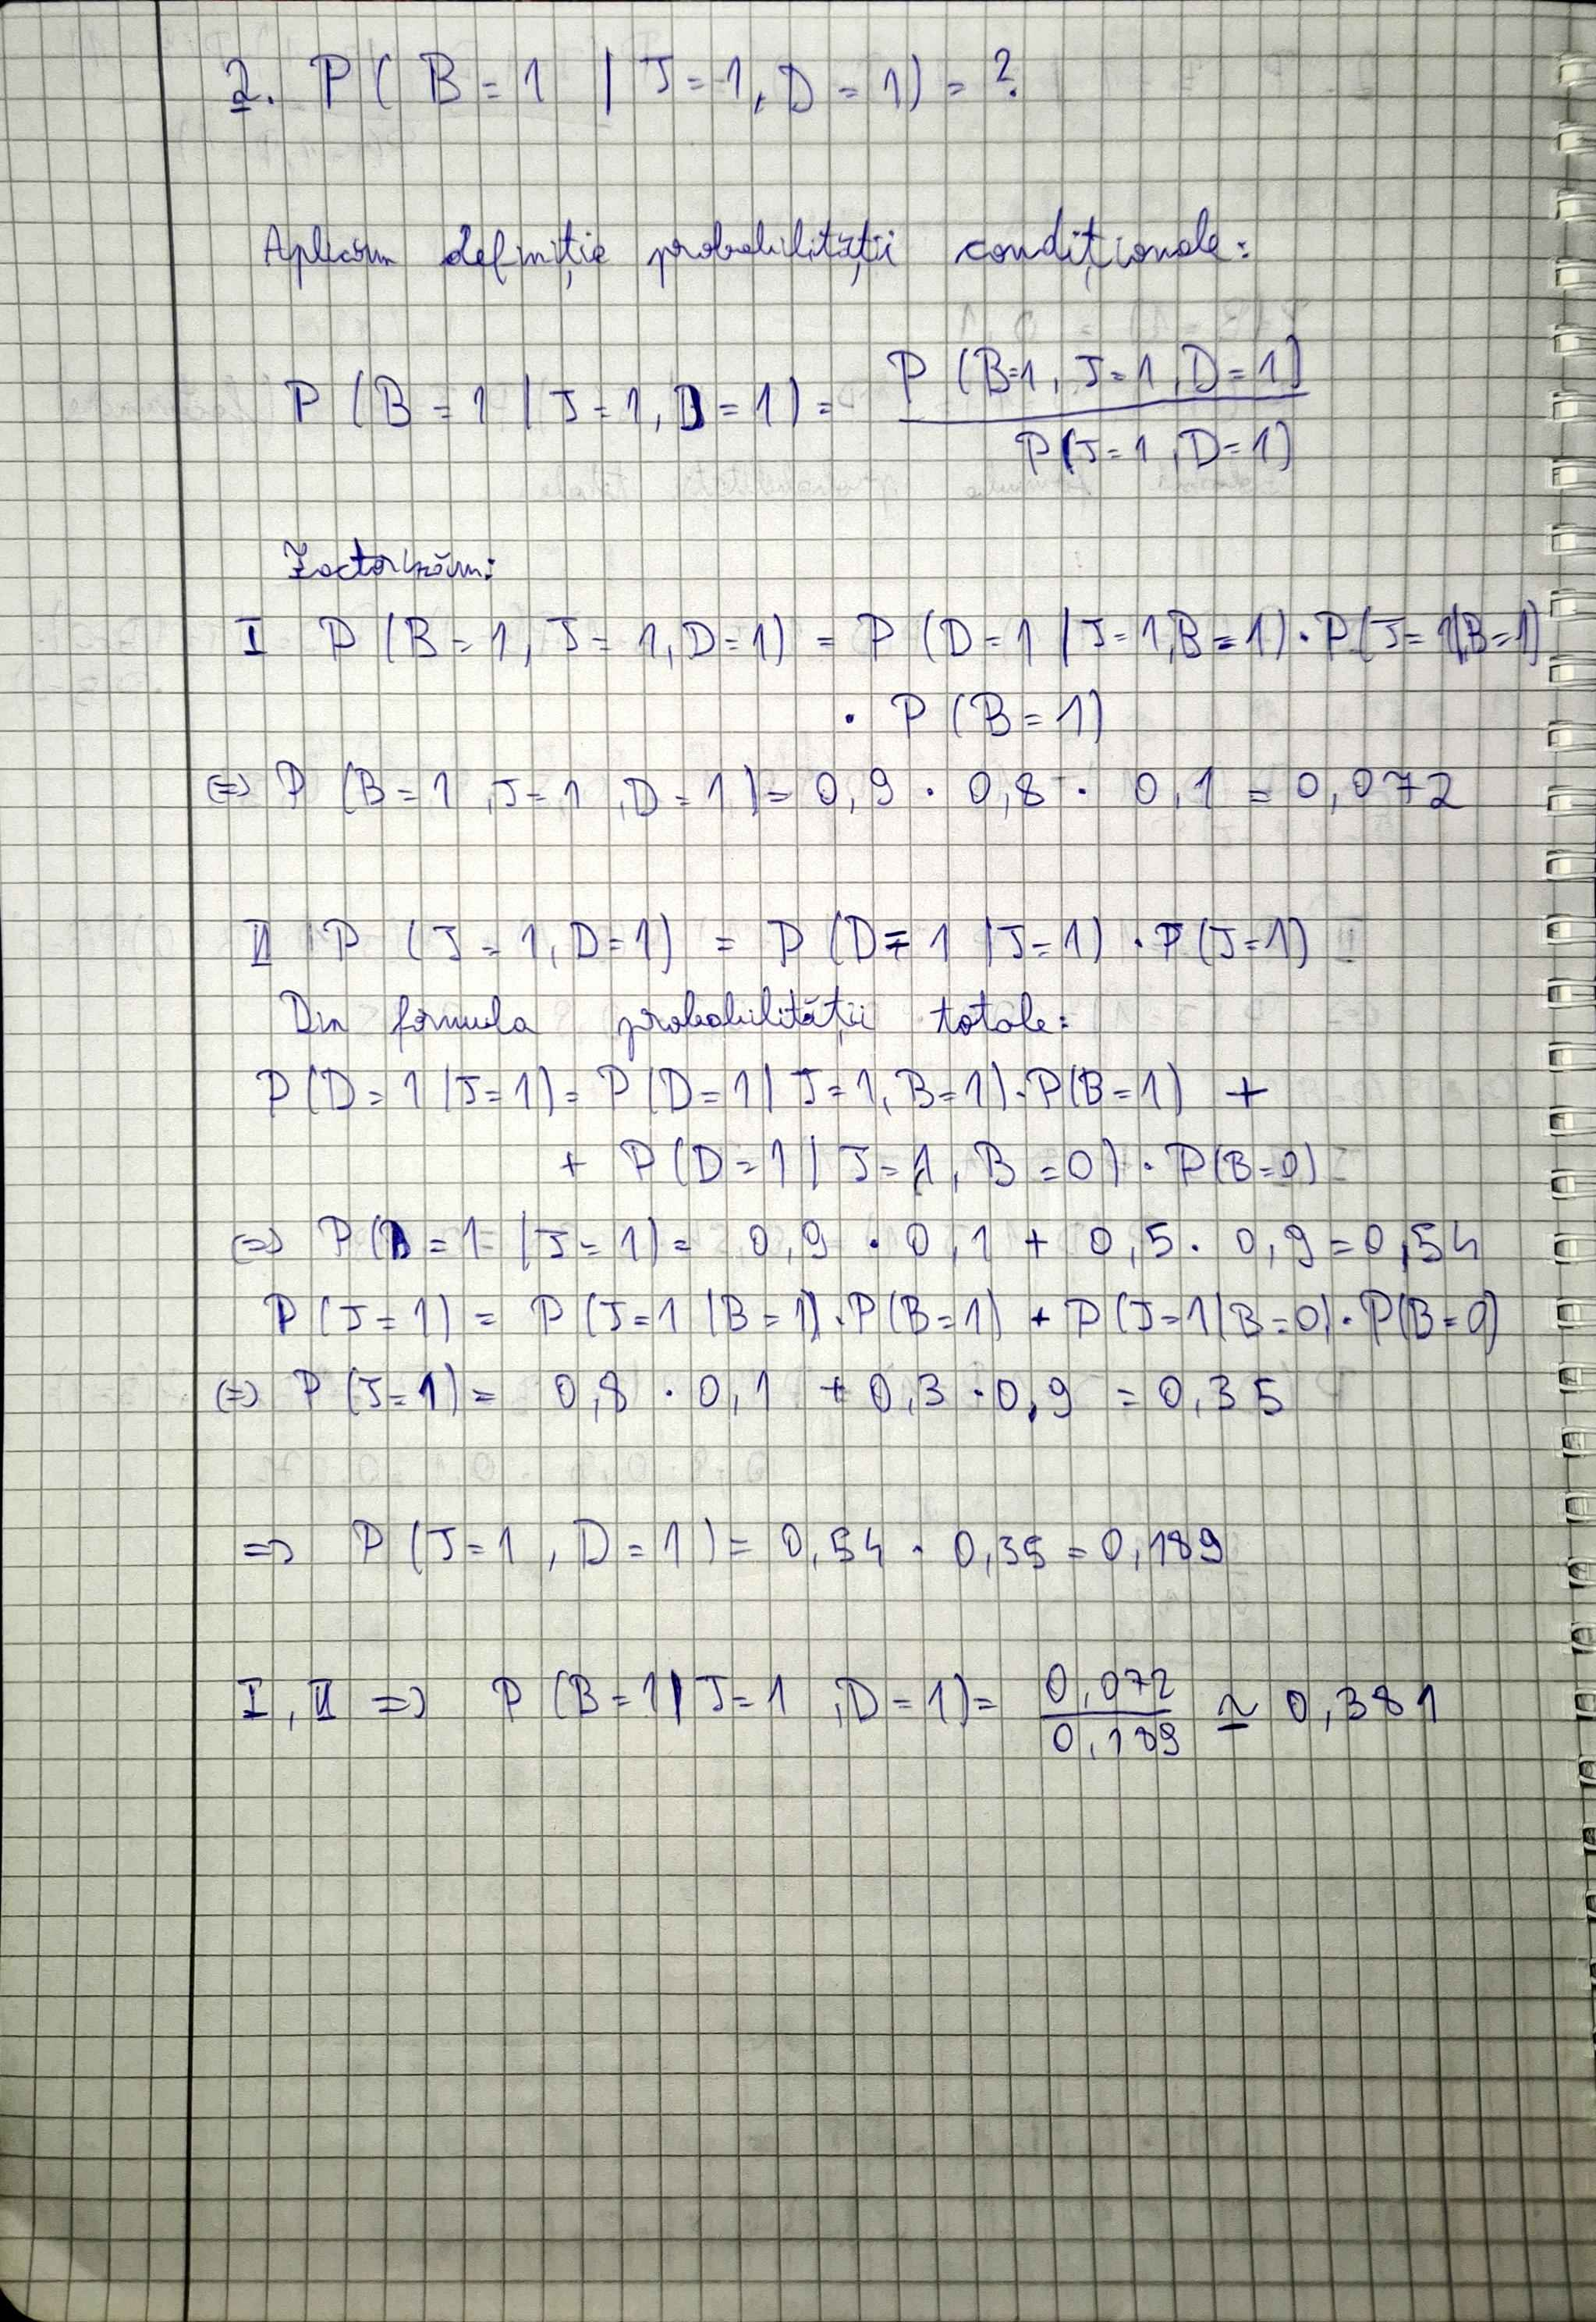

In [3]:
from IPython.display import Image

Image("2.jpg")

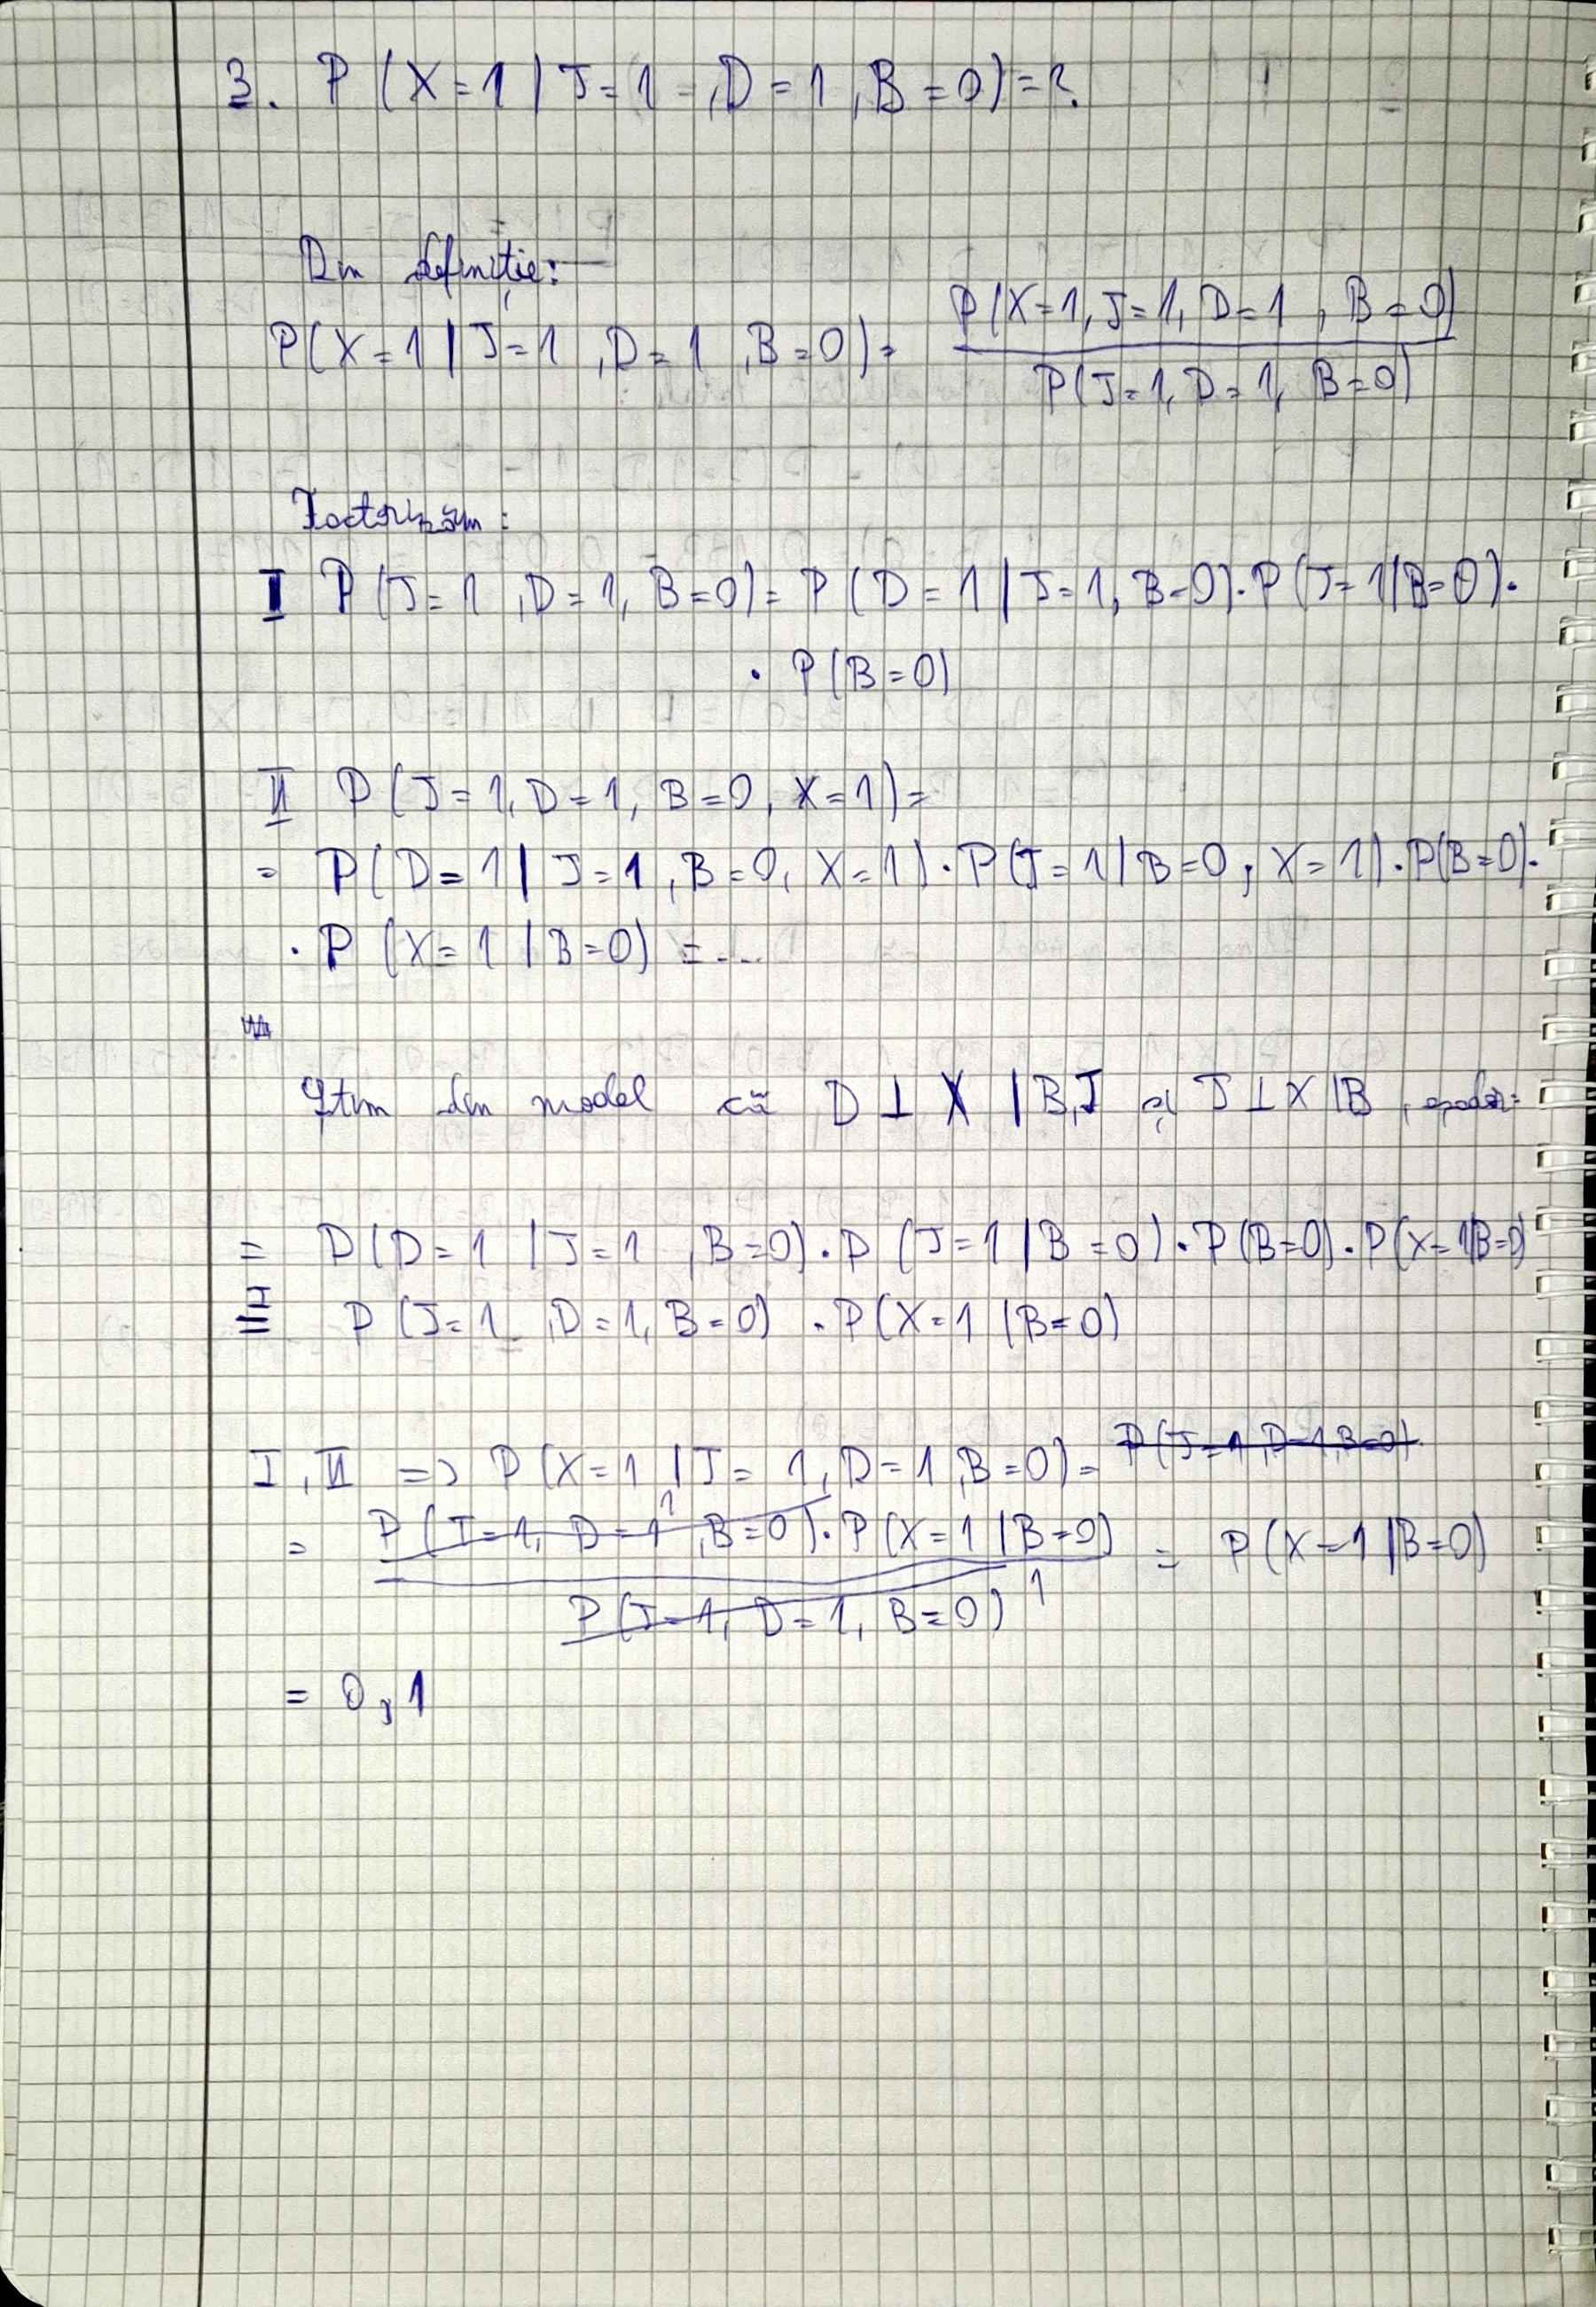

In [2]:
Image("3.jpg")

***Ex. 3*** Un joc între doi jucători, J0 şi J1, se desfăşoară în felul următor:

● se aruncă mai întâi cu o monedă (normală) pentru a decide cine începe: J0 sau J1;

● în prima rundă, jucătorul desemnat aruncă cu propriul zar; fie n numărul obţinut;

● în a doua rundă, celălalt jucător aruncă cu moneda proprie de 2n ori; fie m numărul de steme obţinute.

Jucătorul din prima rundă câştigă dacă n ≥ m, în caz contrar câştigând jucătorul din a doua rundă. Mai ştim că
jucătorul J1 este necinstit, el aducând o monedă măsluită, cu probabilitatea de obţinere a stemei egală cu 4/7. În schimb,
moneda jucătorului J0 este normală, iar cele două zaruri sunt şi ele normale.
1. Estimaţi care dintre cei doi jucători are şansele cele mai mari de câştig, simulând un joc de 10000 ori.

In [52]:
import numpy as np

def coin_throw(weight):
    np.random.choice(["Heads", "Tails"], 1 , [weight, 1-weight])

def game():
    if coin_throw(0.5) == "Heads":
        coin_weight = 0.5 #primul jucator este J0
    else: coin_weight = 3/7 #primul jucator este J1

    n = np.random.choice([1, 2, 3, 4, 5, 6])
    m = 0

    for _ in range (2 * n):
        if coin_throw(coin_weight) == "Tails":
            m = m + 1
    
    if coin_weight == 0.5: #primul jucator a fost J0
        if n >= m:
            return 0
        else: return 1
    else: #primul jucator a fost J1
        if n >= m:
            return 1
        else: return 0

J = [0, 0] #J[0], J[1] respective
for _ in range(10000):
    J[game()] += 1 #tinem cont de castiguri

print(J)

[0, 10000]


*2.* Folosind pgmpy, definiţi o reţea Bayesiană care sa descrie contextul de mai sus.

In [90]:
from numpy.random import binomial

model_game = BayesianNetwork([("Ct", "M"), ("N", "M")])

cpd_ct = TabularCPD("Ct", 2, [[0.5], [0.5]])
cpd_n = TabularCPD("N", 6, [[1/6], [1/6], [1/6], [1/6], [1/6], [1/6]])

Ct_states = [0, 1] #cap, pajura
N_states = [1, 2, 3, 4, 5, 6] #valorile aruncarii unui zar
M_values = []
for ct in Ct_states:
    for n in N_states:
        if ct == 0:
            tails = binomial(2 * n, 0.5, 10000) #cate steme obtine, aproximativ, J0
        else:
            tails = binomial(2 * n, 4/7, 10000) #cate steme obtine, aproximativ avut J1
        
        distribution = [(tails == k).mean() for k in range(2 * n + 1)] #salvam

        if len(distribution) < 13:
            #pentru cand zarul da mai putin de 6, adaugam zero-uri pentru a normaliza lungimea distributiei:
            zeros_needed = 13 - len(distribution)
            distribution.extend([0] * zeros_needed)
        M_values.append(distribution)

#este necesar facut transpusa, intrucat numpy.random.binomial creeaza lista diferit:
M_values_transposed = list(map(list, zip(*M_values)))
    
cpd_m = TabularCPD("M", 13, M_values_transposed, ["Ct", "N"], [2, 6])

model_game.add_cpds(cpd_ct, cpd_n, cpd_m)
model_game.get_cpds()

[<TabularCPD representing P(Ct:2) at 0x1b8d61bcfd0>,
 <TabularCPD representing P(N:6) at 0x1b8d61bdb50>,
 <TabularCPD representing P(M:13 | Ct:2, N:6) at 0x1b8d5e12990>]

In [91]:
model_game.check_model()

True

*3.* Folosind modelul de mai sus, determinaţi cine e cel mai probabil să fi început jocul, ştiind că în a doua rundă s-a
obţinut o singură stemă.

In [92]:
infer_game = VariableElimination(model_game)
posterior_p_game = infer_game.query(["Ct"], evidence={"M": 1})
print(posterior_p_game)

+-------+-----------+
| Ct    |   phi(Ct) |
+=======+===========+
| Ct(0) |    0.5526 |
+-------+-----------+
| Ct(1) |    0.4474 |
+-------+-----------+
